In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
import h5py
import keras
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from hep_VQAE import utils as ut

from keras.initializers import Constant
from keras import backend as K
from keras.layers import PReLU

import tensorflow_addons as tfa

2022-09-14 12:32:50.451944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-14 12:32:50.451975: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-09-14 12:32:54.029412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-14 12:32:54.029446: W tensorflow/

In [2]:
#f3 = h5py.File("../../data/quark-gluon/quark-gluon_train-set_n793900.hdf5","r")
#f2 = h5py.File("../../data/quark-gluon/quark-gluon_test-set_n10000.hdf5","r")
f = h5py.File("small_quark_gluon_12","r")

In [3]:
x_train = f.get('X')
y_train = f.get('y')

#x_val = f2.get('X')
#y_val = f2.get('y')

#x_test = f2.get('X')
#y_test = f2.get('y')

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train[:], y_train[:], test_size=0.2, shuffle=True)

In [5]:
x_train_ones = x_train[y_train==1]
x_train_ones = x_train_ones.reshape(x_train_ones.shape + (1,))
x_train = x_train[y_train==0]
x_train = x_train.reshape(x_train.shape + (1,))

div1 = np.max(x_train, axis=(1,2)).reshape((x_train.shape[0],1,1,1))
div1[div1 == 0] = 1
x_train = x_train / div1
div2 = np.max(x_train_ones, axis=(1,2)).reshape((x_train_ones.shape[0],1,1,1))
div2[div2 == 0] = 1
x_train_ones = x_train_ones / div2

x_val_ones = x_val[y_val==1]
x_val_ones = x_val_ones.reshape(x_val_ones.shape + (1,))
x_val = x_val[y_val==0]
x_val = x_val.reshape(x_val.shape + (1,))

div1 = np.max(x_val, axis=(1,2)).reshape((x_val.shape[0],1,1,1))
div1[div1 == 0] = 1
x_val = x_val / div1
div2 = np.max(x_val_ones, axis=(1,2)).reshape((x_val_ones.shape[0],1,1,1))
div2[div2 == 0] = 1
x_val_ones = x_val_ones / div2


x_test = x_val
x_test_ones = x_val_ones

In [6]:
class Convolutional_Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Convolutional_Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(12, 12, 1)),
          layers.Conv2D(4, kernel_size=4, strides=1, activation='relu', padding='same'),
          layers.Conv2D(4, kernel_size=4, strides=1, activation='relu', padding='same'),
          layers.AveragePooling2D(pool_size=2),
          layers.Conv2D(2, kernel_size=4, strides=1, activation='relu', padding='same'),
          layers.Conv2D(2, kernel_size=4, strides=1, activation='relu', padding='same'),#,
          layers.Flatten(),
          #layers.Dense(36*1, activation='relu'),
          layers.Dense(latent_dim, activation='relu')])

        self.decoder = tf.keras.Sequential([
          layers.Dense(36*1, activation='relu'),
          layers.Reshape((6, 6, 1)),
          layers.Conv2D(2, kernel_size=4, strides=1, activation='relu', padding='same'),# after 14
          layers.Conv2D(2, kernel_size=4, strides=1, activation='relu', padding='same'),
          layers.UpSampling2D(size=2),
          layers.Conv2D(4, kernel_size=4, strides=1, activation='relu', padding='same'),
          layers.Conv2D(4, kernel_size=4, strides=1, activation='relu', padding='same'),# after 14
          layers.Conv2D(1, kernel_size=4, strides=1, activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
import keras

class auccall(keras.callbacks.Callback):
    """Computes the Jaccard score and logs the results to TensorBoard."""

    def __init__(self, model, x_test_bg, x_test_signal):
        self.model = model
        self.x_test_bg = x_test_bg
        self.x_test_signal = x_test_signal
        self.keras_metric = tf.keras.metrics.Mean("jaccard_score")
        self.epoch = 0
        self.hist = []

    def on_epoch_end(self, batch, logs=None):
        self.epoch += 1
        self.keras_metric.reset_state()
        recon_bg = self.model.predict(self.x_test_bg)
        recon_signal = self.model.predict(self.x_test_signal)
        bce_background = tf.keras.losses.binary_crossentropy(self.x_test_bg, recon_bg, axis=(1,2,3)).numpy()
        bce_signal = tf.keras.losses.binary_crossentropy(self.x_test_signal, recon_signal, axis=(1,2,3)).numpy()
        y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
        y_pred = np.append(bce_background, bce_signal)
        auc = roc_auc_score(y_true, y_pred)
        self.hist.append(auc)

In [8]:
model = Convolutional_Autoencoder(20)

In [9]:
model.build(input_shape=(1,12,12,1))

In [10]:
model.summary()

Model: "convolutional__autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 20)                1984      
                                                                 
 sequential_1 (Sequential)   (1, 12, 12, 1)            1313      
                                                                 
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [11]:
x_train_ones = x_train_ones[:10000]
x_train = x_train[:10000]
x_val = x_val[:1200]
x_val_ones = x_val_ones[:1200]

In [12]:
learning_rate = 0.0001
weight_decay = 0.00001
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

In [13]:
#model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.05))
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [14]:
x_train_ones.shape

(10000, 12, 12, 1)

In [15]:
auc_call = auccall(model, x_val_ones, x_val)

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5)
hist = model.fit(x_train_ones,x_train_ones,epochs=1200,validation_data=(x_val_ones,x_val_ones),callbacks=[es,auc_call], batch_size=30)

Epoch 1/1200
334/334 [==============================] - 6s 14ms/step - loss: 0.4111 - val_loss: 0.1736
Epoch 2/1200
334/334 [==============================] - 4s 13ms/step - loss: 0.1362 - val_loss: 0.1005
Epoch 3/1200
334/334 [==============================] - 4s 13ms/step - loss: 0.0778 - val_loss: 0.0660
Epoch 4/1200
334/334 [==============================] - 4s 13ms/step - loss: 0.0641 - val_loss: 0.0610
Epoch 5/1200
334/334 [==============================] - 4s 13ms/step - loss: 0.0609 - val_loss: 0.0591
Epoch 6/1200
334/334 [==============================] - 4s 13ms/step - loss: 0.0596 - val_loss: 0.0582
Epoch 7/1200
334/334 [==============================] - 4s 13ms/step - loss: 0.0586 - val_loss: 0.0574
Epoch 8/1200
334/334 [==============================] - 4s 13ms/step - loss: 0.0579 - val_loss: 0.0567
Epoch 9/1200
334/334 [==============================] - 5s 14ms/step - loss: 0.0572 - val_loss: 0.0561
Epoch 10/1200
334/334 [==============================] - 5s 15ms/step - l

In [17]:
x_test.shape

(13936, 12, 12, 1)

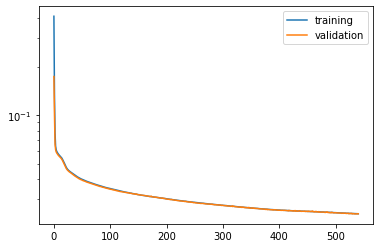

In [18]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

Text(0, 0.5, 'auc')

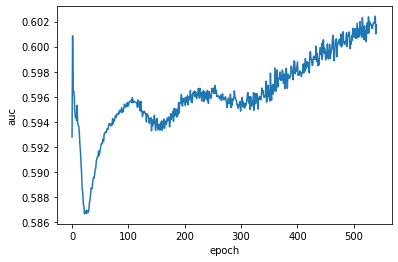

In [19]:
plt.plot(auc_call.hist)
plt.xlabel("epoch")
plt.ylabel("auc")

Collapse_metric: 0.885
Average EMD: 2.86
ssim: 0.853
MAE: 0.0117
normalized MAE: 0.00515


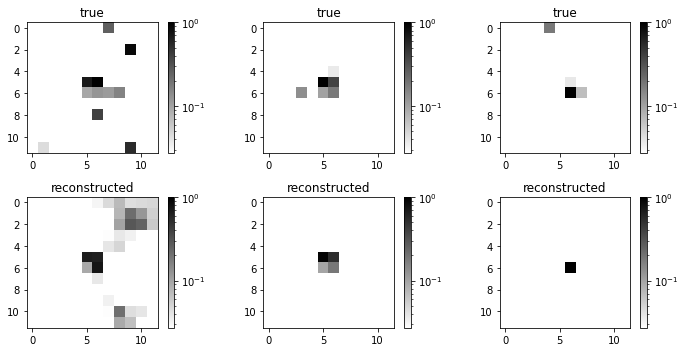

In [20]:
recon = model.predict(x_val)

ut.eval_recon(x_val, recon, lognorm=True)

Collapse_metric: 0.908
Average EMD: 2.27
ssim: 0.891
MAE: 0.009
normalized MAE: 0.00458


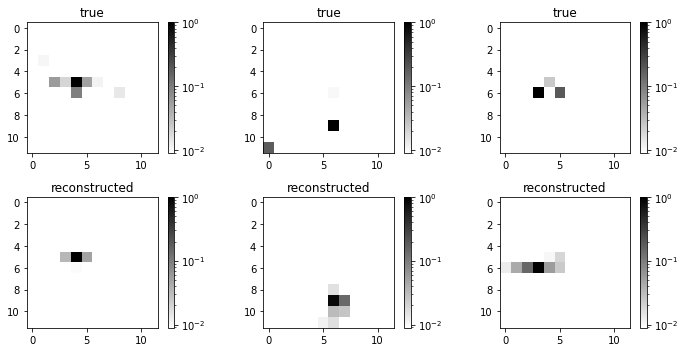

In [21]:
recon = model.predict(x_val_ones)

ut.eval_recon(x_val_ones, recon, lognorm=True)

Median background: 0.0178
Median signal: 0.0251
Maximum accuracy: 0.581
AUC: 0.6017


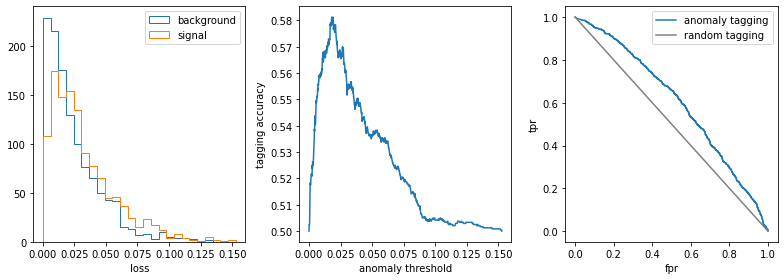

In [22]:
recon = model.predict(x_val)
recon_1 = model.predict(x_val_ones)

ut.eval_tagging(x_val_ones, recon_1, x_val, recon)

In [23]:
recon = model.predict(x_test)
recon_1 = model.predict(x_test_ones)

emds = [ut.img_emd(x,y) for x,y in zip(x_test, recon)]
emds_1 = [ut.img_emd(x,y) for x,y in zip(x_test_ones, recon_1)]

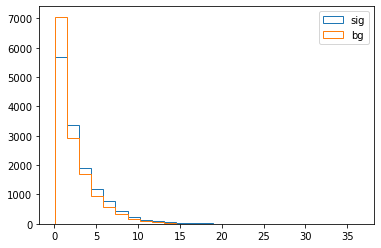

In [24]:
bins = np.histogram(np.hstack((emds, emds_1)), bins=25)[1]
plt.hist(emds, histtype="step", label="sig", bins=bins)
plt.hist(emds_1, histtype="step", label="bg", bins=bins)
plt.legend()

In [25]:
emds_1 = 1 - np.array(emds_1)
emds = 1 - np.array(emds)

In [26]:
y_true = np.append(np.ones(len(emds_1)), np.zeros(len(emds)))
y_pred = np.append(emds_1, emds)
auc = roc_auc_score(y_true, y_pred)

In [27]:
auc

0.5701786443572142

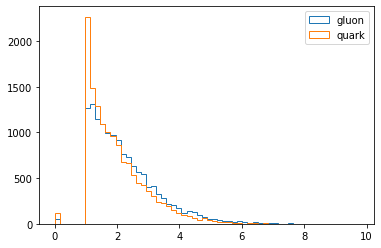

In [28]:
zerosum = np.sum(x_test, axis=(1,2))
onesum = np.sum(x_test_ones, axis=(1,2))
bins = np.histogram(np.hstack((zerosum.reshape((zerosum.shape[0],)), onesum.reshape((onesum.shape[0],)))), bins=60)[1]

plt.hist(zerosum, histtype="step", label="gluon", bins=bins)
plt.hist(onesum, histtype="step", label="quark", bins=bins)
plt.legend()

AUC:  0.574413515


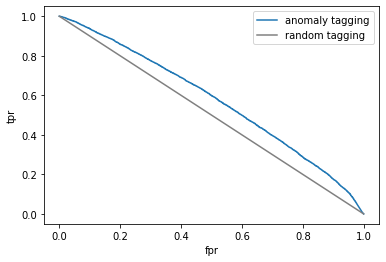

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

#bce_background = 1-pred_six
#bce_signal = 1-pred_three
bce_background = 1-zerosum[:10000]
bce_signal = 1-onesum[:10000]

y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
y_pred = np.append(bce_background, bce_signal)
auc = roc_auc_score(y_true, y_pred)

print("AUC: ", auc)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
tnr = 1 - fpr
x = np.linspace(0,1,50)
y_rnd = 1 - x
plt.plot(tnr,tpr, label="anomaly tagging")
plt.plot(x,y_rnd, label="random tagging", color='grey')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()